In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray

In [3]:
from study import V27, neutral

# Estimate inflow from upstream plane
- velocity profile $= \bar{U}(t,z)$
- $\bar{U}$ is a 1-min rolling mean
- need offset in time from the x=-2.5D plane to the downstream wake planes

In [4]:
casedir = 'WAKEBENCH-NREL_DEBNATH_LES/neutral'
prefix = 'NREL_DEBNATH_LES_20190325'

In [5]:
case = neutral(casedir,prefix,turbine=V27)

## Load data into wake object

In [7]:
xa = xarray.open_dataset(case.get_wake_datafile(case.upstreamD))
xa

Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_-2.5D.nc


<xarray.Dataset>
Dimensions:  (t: 1663, x: 1, y: 162, z: 162)
Coordinates:
  * t        (t) uint16 16150 16151 16152 16153 ... 17809 17810 17811 17812
  * x        (x) float64 -67.5
  * y        (y) float64 -40.0 -39.51 -39.01 -38.51 ... 38.51 39.01 39.51 40.0
  * z        (z) float64 0.4979 0.9949 1.492 1.989 ... 79.01 79.51 80.01 80.5
Data variables:
    U        (t, x, y, z) float64 ...
    V        (t, x, y, z) float64 ...
    W        (t, x, y, z) float64 ...

In [8]:
Ntimes = xa.dims['t']

In [9]:
t = xa.t.values
z = xa.z.values

In [10]:
xa.U

<xarray.DataArray 'U' (t: 1663, x: 1, y: 162, z: 162)>
[43643772 values with dtype=float64]
Coordinates:
  * t        (t) uint16 16150 16151 16152 16153 ... 17809 17810 17811 17812
  * x        (x) float64 -67.5
  * y        (y) float64 -40.0 -39.51 -39.01 -38.51 ... 38.51 39.01 39.51 40.0
  * z        (z) float64 0.4979 0.9949 1.492 1.989 ... 79.01 79.51 80.01 80.5
Attributes:
    long_name:  streamwise wind component
    units:      m/s

## get profile

In [11]:
Uprofile_inst = xa.U.mean(dim=('x','y')) # average over x,y: U(t,z)
Uprofile_mean = Uprofile_inst.rolling(dim={'t':case.Navg}).mean()

In [12]:
Uprofile = Uprofile_mean.to_dataframe(name='U')

## read turbine output

In [13]:
turb = pd.read_csv(case.get_turbine_datafile()).set_index('time_[s]')

Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_wtg_response.txt


In [14]:
turb.index

Float64Index([   0.0,    0.1,    0.2,    0.3,    0.4,    0.5,    0.6,    0.7,
                 0.8,    0.9,
              ...
              1843.1, 1843.1, 1843.1, 1843.1, 1843.1, 1843.1, 1843.1, 1843.1,
              1843.1, 1843.1],
             dtype='float64', name='time_[s]', length=18501)

In [15]:
turb.columns

Index(['blade_pitch_[deg]', 'blade_root_edge_moment_[N_m]',
       'blade_root_flap_moment_[N_m]', 'generator_power_[kW]',
       'generator_torque_[N_m]', 'hub_wind_speed_[m_s-1]', 'rotor_power_[kW]',
       'rotor_speed_[rpm]', 'rotor_torque_[N_m]', 'thrust_coefficient_[-]',
       'thrust_force_[N]', 'total_thrust_force_[N]'],
      dtype='object')

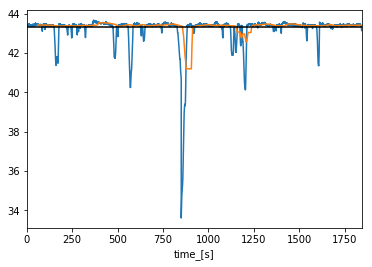

In [16]:
turb['rotor_speed_[rpm]'].plot()
turb['rotor_speed_[rpm]'].rolling(600).median().plot()
omg = turb['rotor_speed_[rpm]'].rolling(600).median().mean()
plt.gca().axhline(omg,ls='-',color='k')

In [17]:
omg

43.339156413259374

## inherent scales

### large-eddy turnover time

In [18]:
Teddy = case.zi / case.Uref # [s]
Teddy

86.20689655172414

### rotor period

In [19]:
Trotor = 1/omg * 60 # [s]
Trotor

1.3844293467060502

### integral time scale

In [47]:
df = xa.to_dataframe()
df.head()

U         V         W
t     x     y     z                                    
16150 -67.5 -40.0 0.497933  3.78682 -0.069897  0.062628
                  0.994865  3.98273 -0.404492  0.123900
                  1.491800  4.19350 -0.708643  0.135786
                  1.988730  4.36773 -1.040070  0.142509
                  2.485660  4.72891 -1.311610  0.129787

In [48]:
khub = np.argmin(np.abs(z - case.turbine.zhub))
z[khub], case.turbine.zhub, z[khub+1]

(32.3016, 32.1, 32.7985)

In [49]:
zref = 32.7985

In [50]:
# select ~hub height
df = df.xs(zref, level='z')

In [51]:
# drop x index
df = df.reset_index(1).drop(columns='x')

0.8682451767722106

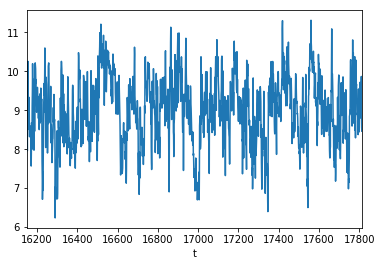

In [151]:
df.xs(0.25,level='y')['U'].plot()
df.xs(0.25,level='y')['U'].std()

0.8392646085716081

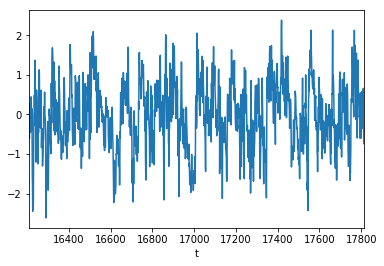

In [155]:
# detrend
u = df['U'] - Uprofile.xs(zref, level='z')['U']
u = u.loc[~pd.isna(u)]
u.xs(0.25,level='y').plot()
u.xs(0.25,level='y').std()

In [143]:
# calculate autocorrelation
#%time R = np.correlate(u.values, u.values, mode='full')
R = u.unstack().apply(lambda u_y: np.correlate(u_y, u_y, mode='full'), axis=0)
Rmean = R.mean(axis=1).values[len(R)//2:]
Rmean /= Rmean[0] # normalize by the stdev, i.e., a one-point correlation at dt=0

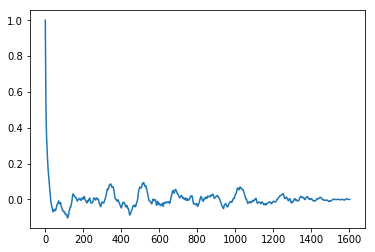

In [144]:
plt.plot(np.arange(len(Rmean)),Rmean)

In [145]:
# integral time scale of turbulence
Tint = np.sum(Rmean)
Tint

2.8073148304190867

(0, 500)

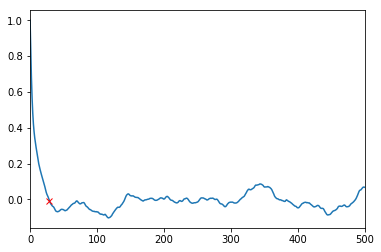

In [161]:
imax = np.where(Rmean < 0)[0][0]
plt.plot(np.arange(len(Rmean)),Rmean)
plt.plot(imax,Rmean[imax],'rx')
plt.xlim((0,500))

In [163]:
# integral time scale of turbulence, neglecting anticorrelation noise
Tint = np.sum(Rmean[:imax])
Tint

7.524551301849809